# Master the Most Hated Task in DS/ML
## Cleaning categorical data
<img src='images/mop.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@pixabay?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pixabay</a>
        on 
        <a href='https://www.pexels.com/photo/brown-wooden-floor-48889/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Introduction

### Setup

In [94]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

### Categorical Data, Understanding And Examples

The formal definition of categorical data would be:
> A predefined set of possible categories or groups an observation can fall into.

You can see examples of categorical data in almost all the datasets you have worked on. Almost any type of data can be turned into categorical. For example:
- Survey responses:
    * `Yes` or `No`
    * `male` or `female`
    * `employed` or `unemployed`
- Numeric data:
    * Annual income in groups: `0-40k`, `40-100k`, ...
    * Ages: child, teenager, adult ...

As we are learning data cleaning using `panads` library, it is important to understand that `pandas` will never import categorical data as categorical. It is mostly imported as strings or integers:

In [95]:
diamonds = pd.read_csv('data/diamonds.csv', index_col=0)
diamonds.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

You can see that `cut`, `color` and `clarity` are imported as strings rather than as categorical. We could have used the `dtype` parameter of `read_csv` like this:

In [96]:
diamonds = pd.read_csv('data/diamonds.csv',
                       dtype={
                           'cut': 'category',
                           'color': 'category',
                           'clarity': 'category'
                       }, index_col=0)

diamonds.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

But with real-world datasets, you often do not have this luxury because the data you will be working probably will have many categorical variables and often, you will be completely unfamiliar with the data. 

Right after you identify the categorical variables, there are some checks and cleaning to be done before you convert the columns to categorical.

### Dealing With Categorical Data Problems

When you work with real-world data, it will be filled with cleaning problems.

As I wrote in the first part of the series, people collecting data won't take into account the cleanliness of the data and do what it takes to record the necessary information in an easy manner as possible. 

Also, problems will arise because of free text during the collection process which leads to typos, many representations of the same value, etc. It is also possible that errors are introduced because of data parsing errors or bad database design.

For example, consider this worst-case scenario: you are working on a survey data conducted across USA and there is a `state` column for the state of each observation in the dataset. There are 50 states in the USA and imagine all the damn variations of state names people can come up with. You are in even bigger problem if data collectors decide to use abbreviations:
- CA, ca, Ca, Caliphornia, Californa, Calfornia, calipornia, CAL, CALI, ...

Such columns will always be filled with typos, errors, inconsistencies. Never imagine that you will have a smooth one-to-one mapping of categories. 

Before moving on to analysis, you have to establish what is called membership constraints which clearly defines the number of categories and how they are represented in a single format.

### Membership Constraints

There are 3 ways you can treat categorical data problems:
- dropping 
- remapping categories
- inferring categories

First, we will focus on isolating inconsistent observations and dropping them. I have created a fake data to illustrate how it is done in code:

In [97]:
# Create possible values for the fake date
first_names = [
    'Lane', 'Ivor', 'Roary', 'Shannon', 'Abdul', 'Mary', 'Cole', 'Desirae'
]

last_names = ['Reese', 'Pierce', 'Gibson', 'Little', 'Fry', 'Colon', 'Palmer']

blood_types = ['O+', 'O-', 'B+', 'B-', 'A+', 'A-', 'AB+', 'AB-', 'C+', 'D-']
probabilites = [0.12, 0.13, 0.13, 0.12, 0.13, 0.12, 0.12, 0.12, 0.005, 0.005]
marriage_status = [
    ' married', 'married', 'unmarried ', 'unmarried', 'MARRIED', 'UNMARRIED',
    'divorced', 'separated'
]
size = 10000

dirty_dict = {
    'first_name': np.random.choice(first_names, size),
    'last_name': np.random.choice(last_names, size),
    'blood_type': np.random.choice(blood_types, size, p=probabilites),
    'marriage_status': np.random.choice(marriage_status, size),
    'income': np.random.choice(np.arange(40000, 200000, 15000), size)
}

# Data frame from dirty dict with size 10k
sample = pd.DataFrame(dirty_dict)
sample.to_csv('data/incorrect_blood.csv', index=False)

In [98]:
demographics = pd.read_csv('data/incorrect_blood.csv')
demographics.head(5)

,first_name,last_name,blood_type,marriage_status,income
0,Abdul,Little,AB+,unmarried,85000
1,Abdul,Fry,B-,unmarried,175000
2,Roary,Gibson,B-,unmarried,190000
3,Desirae,Fry,A+,married,85000
4,Abdul,Palmer,A-,divorced,175000


It is often the case that you will have some background information about your data. For example, let's say you want to check for inconsistencies in the `blood_type` column of the above data frame. You find out beforehand that `blood_type`  can only have these categories: **\[A+, A-, B+, B-, O+, O-, AB+, AB-\]**. So, you have to make sure that the column in the data source only includes these values. 

In our case, there are 10k rows and visual search for inconsistencies is not an option, which is also the case for many other real-world data. Here is how can implement the best solution for such problems:

First, you should create a new data frame which holds all the possible values for a categorical column:

In [99]:
categories = pd.DataFrame(
    {'blood_type': ['O+', 'O-', 'B+', 'B-', 'A+', 'A-', 'AB+', 'AB-']})
categories

,blood_type
0,O+
1,O-
2,B+
3,B-
4,A+
5,A-
6,AB+
7,AB-


> It is a good practice to create such data frames which hold category mappings for each categorical column in the main data.

As we now have the correct categories in a separate data frame, we can use a basic set operation which gives us the difference of unique values in the two columns:

In [100]:
# Create a set of unique blood types of the main data frame
unique_types_main = set(demographics['blood_type'].unique())
inconsistent_cats = unique_types_main.difference(categories['blood_type'])
inconsistent_cats

{'C+', 'D-'}

To get the difference of two sets, we use `.difference` function. It basically returns all the values from the left set that are not in the right set. Here is a very simple example:

In [101]:
set_1 = {'A', 'B', 'C', 'D'}
set_2 = {'C', 'D', 'E'}
set_1.difference(set_2)

{'A', 'B'}

Attentive readers may have noticed that inside the `set` function, I also called `.unique()` on the `blood_type`. From what I have read from one StackOverflow thread, it seems that the time it takes to get the unique values will be much shorter if you use both `set` and `unique` for larger datasets. 

Now, we will filter our main data for the blood types 'C+' and 'D-':

In [102]:
inconsistent = demographics['blood_type'].isin(inconsistent_cats)
inconsistent

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: blood_type, Length: 10000, dtype: bool

Using `isin` on `blood_type` will return a boolean series which we can use to index the data frame:

In [103]:
inconsistent_rows = demographics[inconsistent]
inconsistent_rows

,first_name,last_name,blood_type,marriage_status,income
58,Lane,Little,D-,married,85000
121,Lane,Colon,D-,married,145000
157,Cole,Gibson,D-,married,190000
243,Cole,Gibson,C+,unmarried,115000
351,Abdul,Colon,D-,unmarried,55000
...,...,...,...,...,...
9308,Lane,Reese,D-,married,85000
9410,Cole,Little,C+,married,130000
9542,Cole,Gibson,C+,unmarried,190000
9937,Lane,Fry,C+,MARRIED,100000


So, there are 142 individuals with incorrect blood types. Since we don't have any insight of how these errors occurred, we have to drop them. It can be done in two ways:

In [104]:
# Using drop
demographics = demographics.drop(inconsistent_rows.index)
# Using negative conditioning
demographics = demographics[~inconsistent]
# Check the results
assert set(demographics['blood_type'].unique()) == set(
    categories['blood_type'])

As our column is clean now, it is safe to set it as a categorical variable:

In [105]:
# Set blood_type as a categorical variable
demographics['blood_type'] = demographics['blood_type'].astype('category')
# Check that the results are in effect
assert demographics['blood_type'].dtype == 'category'

### Value Inconsistency


Just like we talked in the second section, there may be many representations of the same category in the data set. These errors may occur just because simple typos, capitalization, you name it. Continuing cleaning our data, the turn has come to the `marriage_status` column:

In [106]:
demographics['marriage_status'].value_counts()

MARRIED       1300
married       1272
 married      1238
UNMARRIED     1238
separated     1238
unmarried     1233
unmarried     1189
divorced      1185
Name: marriage_status, dtype: int64

Using `value_counts` on a data frame column returns the count of unique values in that column. If you look at the result, you can immediately see the issues. The values should be either lower-case or upper-case. I prefer lower-case:

In [107]:
demographics['marriage_status'] = demographics['marriage_status'].str.lower()
demographics['marriage_status'].value_counts()

married       2572
unmarried     2471
 married      1238
separated     1238
unmarried     1189
divorced      1185
Name: marriage_status, dtype: int64

Using `.str` on a data frame column enables us to use all the Python string functions on each value of the column. Here, we are using `.lower()` which converts strings to lowercase.

`value_counts` is still returning 6 unique values, why? After paying close attention, you can see that one of the categories has an extra leading whitespace. That's why it is being treated as an individual category. The same can be true for one of the `unmarried`, it might have a trailing whitespace. We can use the string `strip` function to get rid of unwanted characters from a string:

In [108]:
demographics['marriage_status'] = demographics['marriage_status'].str.strip()
demographics['marriage_status'].value_counts()

married      3810
unmarried    3660
separated    1238
divorced     1185
Name: marriage_status, dtype: int64

Now the data is clean. All is left is to convert this column into a category data type too:

In [109]:
# Convert marriage_status to categorical
demographics['marriage_status'] = demographics['marriage_status'].astype(
    'category')
# Check the results
assert demographics['marriage_status'].dtype == 'category'

### Collapsing Data Into Categories

Sometimes, you may want to take already existing data, often numerical, and generate categories from it. This can be useful in a number of cases. 

In our `demographics` dataset, we have an annual income column. It can be useful to cut this column into different income groups because doing so might give some extra insight into the data. 

`pandas` has a perfect function for this: `cut`. It enables us to cut numerical rages like data frame columns into bins and give them custom labels. Let's see it in action:

In [116]:
ranges = [40000, 75000, 100000, 140000, 170000, np.inf]
labels = ['40k-75k', '75k-100k', '100k-140k', '140k-170k', '170k+']
demographics['income_groups'] = pd.cut(demographics['income'], bins=ranges, labels=labels)
demographics.sample(5)

,first_name,last_name,blood_type,marriage_status,income,income_groups
5960,Lane,Reese,A-,unmarried,130000,100k-140k
5439,Shannon,Pierce,O+,unmarried,145000,140k-170k
465,Mary,Little,B+,unmarried,115000,100k-140k
2333,Abdul,Reese,AB-,married,70000,40k-75k
1785,Roary,Fry,B-,unmarried,175000,170k+


Now, we can use functions like `value_counts` to get more insight:

In [119]:
demographics['income_groups'].value_counts(sort=False)

40k-75k      1765
75k-100k     1799
100k-140k    1809
140k-170k    1805
170k+        1800
Name: income_groups, dtype: int64

You can also plot a count plot:

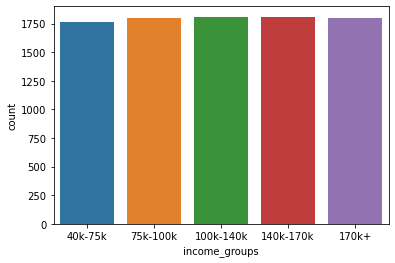

In [121]:
sns.countplot(demographics['income_groups']);